# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pickle
from tqdm import tqdm
import os
from collections import Counter

# ============================== loading libraries ===========================================

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer

from prettytable import PrettyTable

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import itertools


C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import os
print(os.listdir("."))

['.ipynb_checkpoints', '04 Amazon Fine Food Reviews Analysis_NaiveBayes.ipynb', '05 Amazon Fine Food Reviews Analysis_Logistic Regression.ipynb', '05 Amazon Fine Food Reviews Analysis_Logistic Regression_original.ipynb', 'Amazon Logistic Regression Submission.ipynb', 'Amazon_Logistic_Regression_Submission.ipynb', 'database.sqlite', 'Logistic Regression in progress.ipynb', 'LogisticRegression.ipynb', 'LogisticRegression_copy.ipynb', 'Logistic_Regression_from_KNN_fun.ipynb', 'model_avgw2v_l1.pkl', 'model_avgw2v_l2.pkl', 'preprocessed_final', 'sent_vectors_test.pkl', 'sent_vectors_train.pkl', 'Some subtle python operations.ipynb']


In [3]:
# from google.colab import files
# files.upload()

# !pip install -q kaggle

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# !kaggle datasets download -d snap/amazon-fine-food-reviews

# !unzip amazon-fine-food-reviews.zip

##  Data Import and Preprocessing

In [0]:
# Google Drive
#final = pd.read_pickle('/content/drive/My Drive/Aaic/final_0317.pkl')

In [0]:
# Local
#final = final = pickle.load(open('preprocessed_final', 'rb'))

In [8]:
#!ls


amazon-fine-food-reviews.zip  hashes.txt   Reviews.csv
database.sqlite		      kaggle.json  sample_data


In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

In [5]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

In [6]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

In [7]:
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [8]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [9]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [10]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [11]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [13]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [14]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [15]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [16]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [17]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [18]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...


In [19]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

**Observation:** This is an imbalance dataset. There are roughly 84% Positive review and 16% Negative reviews.

*Checkpoint 1: Imported data and some basic eda*

In [0]:
# Filtering 1 (positive) and 0 (negative) reviews
#pos_reviews = final[final['Score'] == 1].sample(n=10000, random_state=507)
#neg_reviews = final[final['Score'] == 0].sample(n=10000, random_state=507)

# Combining the above dataframes into one
#final = pd.concat([pos_reviews, neg_reviews])

In [20]:
# Converting Time to time format in seconds using a unix epoch time
# We will arrange the entire final dataframe in ascending order for time based splitting

final["Time"] = pd.to_datetime(final["Time"], origin='unix', unit = "s")
final = final.sort_values(by = "Time")

In [21]:
final.size

877730

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [22]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!<br /><br />(For those wo

In [23]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [24]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!(For those wondering, this mix requ

In [25]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [26]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This gum is my absolute favorite. By purchasing on amazon I can get the savings of large quanities at a very good price. I highly recommend to all gum chewers. Plus as you enjoy the peppermint flavor and freshing of breath you are whitening your teeth all at the same time.


In [27]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [28]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This gum is my absolute favorite By purchasing on amazon I can get the savings of large quanities at a very good price I highly recommend to all gum chewers Plus as you enjoy the peppermint flavor and freshing of breath you are whitening your teeth all at the same time 


In [29]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [30]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87773/87773 [00:30<00:00, 2909.84it/s]


In [31]:
preprocessed_reviews[1500]

'gum absolute favorite purchasing amazon get savings large quanities good price highly recommend gum chewers plus enjoy peppermint flavor freshing breath whitening teeth time'

<h2>[3.2] Preprocessing Review Summary</h2>

In [32]:
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())


  2%|██▎                                                                                                                        | 1694/87773 [00:00<00:32, 2682.41it/s]C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 43%|████████████████████████████████████████████████████▍                                                                     | 37757/87773 [00:09<00:11, 4525.80it/s]C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 56%|███████████████████████████████████████████████████████████████████▊                                                      | 48811/87773 [

In [33]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,2003-10-25,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,2003-10-25,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...


In [34]:
final['CleanedText']= preprocessed_reviews
final['CleanedSummary']= preprocessed_summary

In [35]:
final.CleanedText.isnull().sum()

0

In [36]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...,sure death flies
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...,great product
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...,wow make islickers
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,2003-10-25,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",nothing product bother link top page buy used ...,chewed gum many times used
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,2003-10-25,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff sugar free not rot gums tastes good...,best sugarless gum ever


In [0]:
# writing the preprocessed final dataframe to dist
#file_Name = "preprocessed_final"
# open the file for writing
#fileObject = open(file_Name,'wb') 

# this writes the object a to the
# file named 'testfile'
#pickle.dump(final,fileObject)

**Load saved final**

In [0]:
#final = pickle.load(open('preprocessed_final', 'rb'))

In [37]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText', 'CleanedSummary'],
      dtype='object')

 *Checkpoint 2: Data is now sorted based on Time and preprocessed.*

In [38]:
# Create X and Y variable 
X = final['CleanedText'].values
y= final['Score'].values

In [39]:
type(X)

numpy.ndarray

In [40]:
type(y)

numpy.ndarray

In [41]:
# ss
from sklearn.model_selection import train_test_split

# Splitting into train and test in the ratio 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=False, random_state=507)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, shuffle=False, random_state=507)

In [42]:
print("Train Set:",X_train.shape, y_train.shape[0])
print("Test Set:",X_test.shape, y_test.shape[0])

Train Set: (61441,) 61441
Test Set: (26332,) 26332


*Checkpoint 3: Data has been partioned into train, cv and test*

**Defining functions that we will be using throughout the notebook for BoW, TFIDF, AvgW2V, TFIDF-WW2V**

1. **get_best_hyperparameter_C(vectorizer, X_train, X_test, y_train, y_test, penalty)** : This function will run GridSearchCV with cv = 5 and the penalty on the training and test set data specified by the user.  
2. **plot_auc(model, X_train, X_test)**: This funtion will plot the AUC curve
3. **most_informative_feature_for_binary_classification(vectorizer, classifier, n=10)** : This function will return the most imporant features for the positive and the negative class
4. **print_confusion_matrix(model, X_train, X_test)**: Prints the confusion matrix for the train and test set data.
5. **plot_confusion_matrix_heatmap(cm, classes, normalize=False,title='Confusion matrix', cmap=plt.cm.Blues)** : Taken from the official sklearn website, this function will return heatmap representation of the confusion matrix
6. **plot_heatmap_confusion_matrix(model, X_test)**: Calculates the confusion matrix on the dataset provided and passes it to plot_confusion_matrix_heatmap() to print the heatmap

**Finding the hyper parameter C (1/lambda) using RandomSearchCV with cv = 5**

In [43]:
def get_best_hyperparameter_C(vectorizer, X_train, X_test, y_train, y_test, penalty_l):
  
    """
    This funtion takes in the vectorizer,  and performs LogissticRegression hyperparameter tuning using GridSearchCV with 5 fold cv 
    Returns the value of hyperparameter C and draws the error plot for various values of C
  
    Usage: get_best_hyperparameter_C(vectorizer, X_train, X_test, y_train, y_test, penalty)
    """
    tuned_parameters = [{'C': [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]}]
    alpha = [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]  #k
    
    #tuned_parameters = [{'C': [10**-4, 10**-3,10**-2]}]
    #alpha = [10**-4, 10**-3,10**-2]

    # Using GridSearchCVSearchCV with 5 fold cv
    gs_obj = GridSearchCV(LogisticRegression(penalty= penalty_l), tuned_parameters, scoring = 'roc_auc', cv=5)

    gs_obj.fit(X_train, y_train)


    train_auc= gs_obj.cv_results_['mean_train_score']
    train_auc_std= gs_obj.cv_results_['std_train_score']
    cv_auc = gs_obj.cv_results_['mean_test_score'] 
    cv_auc_std= gs_obj.cv_results_['std_test_score']

  
    # draws the error plot
  
    plt.plot(alpha, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

    plt.plot(alpha, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039 
    plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel("log(C)- hyperparamter")
    plt.xscale('log')
    plt.ylabel("AUC")
    plt.title("ERROR PLOT")
    plt.show()
  
  
    # Results of the gs object
  
  
    # Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
    means = gs_obj.cv_results_['mean_test_score']
    stds = gs_obj.cv_results_['std_test_score']


    t1 = PrettyTable()
    t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

    for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
        t1.add_row([round(mean, 3), round(std * 2,5), params])

    print(t1) 
  
    print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
    print("\nThe best score is:{}".format(gs_obj.best_score_))
    print("The best value of C is:{}".format(gs_obj.best_params_))

    # Returns the mean accuracy on the given test data and labels.
    print("Mean Score: {}".format(gs_obj.score(X_test, y_test)))
    
    
    return gs_obj.best_params_
    

**train and test AUC**

In [44]:
def plot_auc(model, X_train, X_test):
    
    """
    This function will plot the AUC for the vectorized train and test data.
    Returns the plot and also the values of auc for train and test
    
    Usage: auc_train, auc_test = plot_auc(model, X_train, X_test)
    """
    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.plot([0,1],[0,1],'k--')
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("ROC Curve")
    plt.show()
    
    print("train AUC: {}".format(auc(train_fpr, train_tpr)))
    print("test AUC: {}".format(auc(test_fpr, test_tpr)))
    
    
    return auc(train_fpr, train_tpr), auc(test_fpr, test_tpr)
    

**important features**

In [45]:
# https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
  
    """
     Takes in the vectorizer, classifier (model) and the number of important features to return
  
     Usage: most_informative_feature_for_binary_classification(vectorizer, classifier, n=10)
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class_0 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class_1 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    t1 = PrettyTable()
    t1.field_names = ['Class', 'Coefficient (Importance)', 'Feature Name']
    
    for coef, feat in topn_class_0:
        t1.add_row([class_labels[0], abs(coef), feat])

    print(t1)
    
    print("*"*52)
    
    t2 = PrettyTable()
    t2.field_names = ['Class', 'Coefficient (Importance)', 'Feature Name']
 
    for coef, feat in reversed(topn_class_1):
        t2.add_row([class_labels[1], abs(coef), feat])
      
      
    print(t2)  

    #for coef, feat in topn_class1:
        #if coef < 0:
        #print(class_labels[0], abs(coef), feat)

    #print("*"*30)

    #for coef, feat in reversed(topn_class2):
        #if coef > 0:
     #   print(class_labels[1], abs(coef), feat)

**print confustion matrix**

In [46]:
def print_confusion_matrix(model, X_train, X_test):
    """
    Takes in the model, X_train, X_test and prints the confusion matrix
    Usage: print_confusion_matrix(model, X_train, X_test)
    """
    print("*****Train confusion matrix*****")
    print(confusion_matrix(y_train, model.predict(X_train)))
    print("\n*****Test confusion matrix*****")
    print(confusion_matrix(y_test, model.predict(X_test)))

**heat map of confusion matrix**

In [47]:
# Code modified from sklearn tutorial: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

# Heat map of confusion matrix

def plot_confusion_matrix_heatmap(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
     #   cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     #   print("Normalized confusion matrix")
    #else:
      #  print('Confusion matrix')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [48]:
# def plot_heatmap_confusion_matrix(model, X_test):
#     cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
#     np.set_printoptions(precision=2)
#     class_names = ['Negative', 'Positive']
#     # Plot non-normalized confusion matrix
#     plt.figure()
#     plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

In [49]:
# def plot_heatmap_confusion_matrix_train(model, X_train):
#     cnf_matrix = confusion_matrix(y_train, model.predict(X_train))
#     np.set_printoptions(precision=2)
#     class_names = ['Negative', 'Positive']
#     # Plot non-normalized confusion matrix
#     plt.figure()
#     plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');
    

# [4.1] BAG OF WORDS

In [50]:
# ss
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer= CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
bow_vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = bow_vectorizer.transform(X_train)
#X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = bow_vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
#print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(61441, 10000) (61441,)
(26332, 10000) (26332,)


In [51]:
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of cut text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words: ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text BOW vectorizer  (61441, 10000)
the number of unique words:  10000


**Standardize the data**

In [52]:
# We will set the attribute with_mean = False, as StandardScaler does not work on sparse matrix
# when attempted on sparse matrices, because centering them entails building a dense matrix which in common use cases
# is likely to be too large to fit in memory.  ---> sklearn documentation

from sklearn.preprocessing import StandardScaler
X_train_bow=StandardScaler(with_mean=False).fit_transform(X_train_bow)
X_test_bow=StandardScaler(with_mean=False).fit_transform(X_test_bow)

print(X_train_bow.shape, y_train.shape) 

print(X_test_bow.shape, y_test.shape) 

C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(61441, 10000) (61441,)
(26332, 10000) (26332,)


### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [107]:
# Free up some space
del final,display, preprocessed_reviews, preprocessed_summary, X, y, sorted_data, filtered_data, actualScore, sent_0, sent_1000, sent_150, sent_1500, sent_4900
#del sent_vectors_cv, sent_vectors_test, sent_vectors_train
#del tfidf_sent_vectors_train, tfidf_sent_vectors_cv, tfidf_sent_vectors_test
#del list_of_sentance_cv, list_of_sentance_test, list_of_sentance_train
#del dictionary, stopwords, tfidf_feat, w2v_words

C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


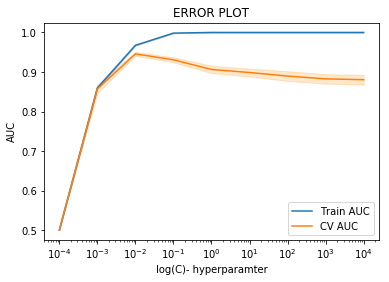

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|      0.5      |     0.0      | {'C': 0.0001} |
|     0.857     |   0.02148    |  {'C': 0.001} |
|     0.946     |   0.00967    |  {'C': 0.01}  |
|     0.931     |   0.01305    |   {'C': 0.1}  |
|     0.906     |   0.01855    |    {'C': 1}   |
|     0.899     |   0.01977    |   {'C': 10}   |
|      0.89     |   0.02458    |   {'C': 100}  |
|     0.883     |   0.02402    |  {'C': 1000}  |
|      0.88     |   0.02441    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The best score is:0.945815885045128
The best value of C is:{'C': 0.01}
Mean S

In [53]:
# Vectorizer = BoW, penalty = l1
best_estimator_bow_l1= get_best_hyperparameter_C(bow_vectorizer, X_train_bow, X_test_bow, y_train, y_test, penalty_l = 'l1' )


In [66]:
# https://stackoverflow.com/questions/3097866/access-an-arbitrary-element-in-a-dictionary-in-python
#list(my_dict.keys())[0]
list(best_estimator_bow_l1.values())[0]


0.01

In [54]:
model_bow_l1 = LogisticRegression(C= list(best_estimator_bow_l1.values())[0] ,penalty = 'l1')
model_bow_l1.fit(X_train_bow,y_train)
y_pred = model_bow_l1.predict(X_test_bow)

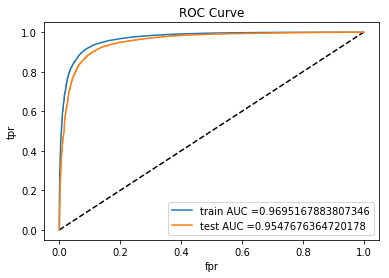

train AUC: 0.9695167883807346
test AUC: 0.9547676364720178


In [55]:
# AUC-ROC plot
auc_train_bow_l1, auc_test_bow_l1 = plot_auc(model_bow_l1, X_train_bow, X_test_bow)

In [56]:
# Confusion Matrix
print_confusion_matrix(model_bow_l1, X_train_bow, X_test_bow)

*****Train confusion matrix*****
[[ 6280  3344]
 [  655 51162]]

*****Test confusion matrix*****
[[ 2785  1772]
 [  376 21399]]


<Figure size 432x288 with 0 Axes>

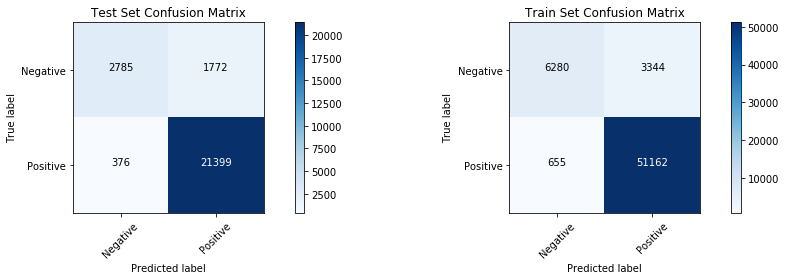

In [57]:
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_bow_l1.predict(X_test_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_bow_l1.predict(X_train_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');


**Observation**
1. For the BoW vectorizer, we calculated C = 0.01 using GridSearchCV with cv = 5 and with penalty l1. 
2. We got train AUC: 0.9695167883807346 and test AUC: 0.9547676364720178
3. Using the confusion matrix, we can say that our model correctly predicted 21399 positive reviews and 2785 negative reviews.
4. The model incorrectly classified 376 negative reviews and 1772 positive reviews.
5. The True Postive Rate is 98.27 and the True Negative Rate is 61.11
6. The accuracy of the model is 91.84

In [58]:
# Confustion Matrix heatmap
#print("Train set")
#plot_heatmap_confusion_matrix(model_bow_l1, X_train_bow)
#plot_heatmap_confusion_matrix_train(model_bow_l1, X_train_bow)
#confusion_matrix(y_train, model_bow_l1.predict(X_train_bow))

# Confustion Matrix heatmap
#print("Train set")
#plot_heatmap_confusion_matrix(model_bow_l1, X_test_bow)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [59]:
# The model has already been fitted. Here we are just going to calculate the sparsity on weight vector 
w = model_bow_l1.coef_
print("The sparsity (no. of non-zero elements) in weight vector is {}".format(np.count_nonzero(w)))

The sparsity (no. of non-zero elements) in weight vector is 1910


**Feature Engineering** Let us perform FE to see if we can further improve the model. Here, we will append length of reviews as another feature.

In [60]:
def get_text_length(x):
    """
     This function takes in a array and returns the length of the elements in the array.
    """
    return np.array([len(t) for t in x]).reshape(-1, 1)

In [61]:
rev_len_X_train = get_text_length(X_train)
rev_len_X_test = get_text_length(X_test)

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer_fe = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
bow_vectorizer_fe.fit(X_train) # fit has to happen only on train data

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=10,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [63]:
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = bow_vectorizer_fe.transform(X_train)
X_test_bow = bow_vectorizer_fe.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(61441, 10000) (61441,)
(26332, 10000) (26332,)


**Standardize the data**

In [64]:
# We will set the attribute with_mean = False, as StandardScaler does not work on sparse matrix
# when attempted on sparse matrices, because centering them entails building a dense matrix which in common use cases
# is likely to be too large to fit in memory.  ---> sklearn documentation

from sklearn.preprocessing import StandardScaler
X_train_bow=StandardScaler(with_mean=False).fit_transform(X_train_bow)
X_test_bow=StandardScaler(with_mean=False).fit_transform(X_test_bow)

print(X_train_bow.shape, y_train.shape) 

print(X_test_bow.shape, y_test.shape) 

C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(61441, 10000) (61441,)
(26332, 10000) (26332,)


In [65]:
type(rev_len_X_train)


numpy.ndarray

In [66]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [67]:
from scipy.sparse import hstack
# Here we append the sparse matrix and the dense array that contains the length of the text passed to it
X_train_bow_fe = hstack((X_train_bow, np.array(rev_len_X_train)))
X_test_bow_fe = hstack((X_test_bow, np.array(rev_len_X_test)))

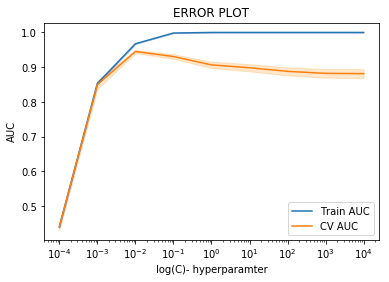

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|      0.44     |   0.01866    | {'C': 0.0001} |
|     0.849     |   0.02492    |  {'C': 0.001} |
|     0.945     |   0.00919    |  {'C': 0.01}  |
|     0.931     |   0.01316    |   {'C': 0.1}  |
|     0.906     |   0.01843    |    {'C': 1}   |
|     0.898     |    0.0208    |   {'C': 10}   |
|     0.888     |   0.02375    |   {'C': 100}  |
|     0.882     |   0.02482    |  {'C': 1000}  |
|     0.881     |   0.02594    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The best score is:0.9450663381665366
The best value of C is:{'C': 0.01}
Mean 

In [68]:
# Get the best hyperparameter using GridSearchCV with penalty l1 and cv = 5
best_estimator_bow_l1_fe = get_best_hyperparameter_C(bow_vectorizer_fe, X_train_bow_fe, X_test_bow_fe, y_train, y_test, penalty_l = 'l1' )

In [69]:
# Fitting the BoW vectorizer on LogisticRegression Model with penalty l1 and C = 0.01 
model_bow_l1_fe = LogisticRegression(C= list(best_estimator_bow_l1_fe.values())[0] ,penalty = 'l1')
model_bow_l1_fe.fit(X_train_bow_fe,y_train)
y_pred = model_bow_l1_fe.predict(X_test_bow_fe)

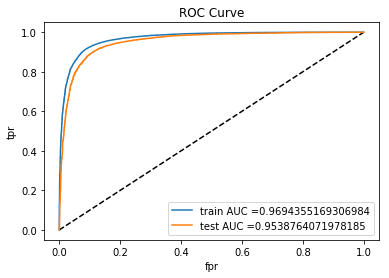

train AUC: 0.9694355169306984
test AUC: 0.9538764071978185


In [70]:
# AUC-ROC plot
auc_train_bow_l1_fe, auc_test_bow_l1_fe = plot_auc(model_bow_l1_fe, X_train_bow_fe, X_test_bow_fe)

In [71]:
# Confusion Matrix
print_confusion_matrix(model_bow_l1_fe, X_train_bow_fe, X_test_bow_fe)

*****Train confusion matrix*****
[[ 6274  3350]
 [  652 51165]]

*****Test confusion matrix*****
[[ 2788  1769]
 [  362 21413]]


<Figure size 432x288 with 0 Axes>

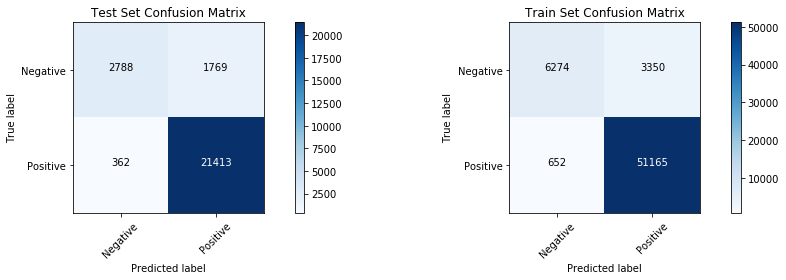

In [72]:
# Confustion Matrix heatmap
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_bow_l1_fe.predict(X_test_bow_fe))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_bow_l1_fe.predict(X_train_bow_fe))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the BoW vectorizer with Feature Engineering, we calculated C = 0.01 using GridSearchCV with cv = 5 and with penalty l1. 
2. We got train AUC: 0.9694354808358998 and test AUC: 0.9538772738827763
3. Using the confusion matrix, we can say that our model correctly predicted 21413 positive reviews and 2788 negative reviews.
4. The model incorrectly classified 362 negative reviews and 1769 positive reviews.
5. The True Postive Rate is 98.33 and the True Negative Rate is 61.18
6. The overall accuracy of the model is 91.90
7. **Doing Feature Engineering has made the model slightly perform better than the model without feature engineering.**


**Observation**

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-

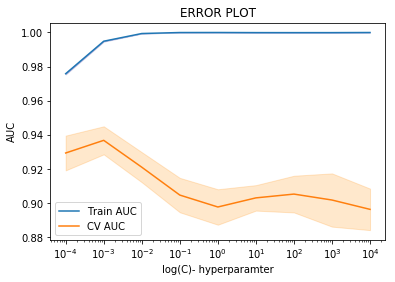

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|     0.929     |   0.02038    | {'C': 0.0001} |
|     0.937     |   0.01645    |  {'C': 0.001} |
|     0.921     |   0.01764    |  {'C': 0.01}  |
|     0.905     |   0.02018    |   {'C': 0.1}  |
|     0.898     |   0.02079    |    {'C': 1}   |
|     0.903     |   0.01494    |   {'C': 10}   |
|     0.905     |   0.02151    |   {'C': 100}  |
|     0.902     |   0.03122    |  {'C': 1000}  |
|     0.896     |   0.02433    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The best score is:0.9367812057739767
The best value of C is:{'C': 0.001}
Mea

In [73]:
# Vectorizer = BoW, penalty = l2
best_estimator_bow_l2= get_best_hyperparameter_C(bow_vectorizer, X_train_bow, X_test_bow, y_train, y_test, penalty_l = 'l2' )

In [74]:
# Fitting the model with the best hyperparameter
model_bow_l2 = LogisticRegression(C= list(best_estimator_bow_l2.values())[0] ,penalty = 'l2')
model_bow_l2.fit(X_train_bow,y_train)
y_pred = model_bow_l2.predict(X_test_bow)

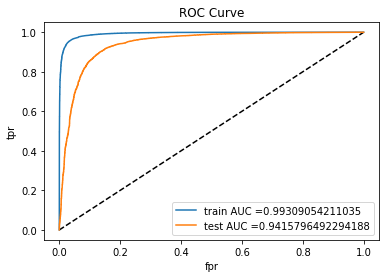

train AUC: 0.99309054211035
test AUC: 0.9415796492294188


In [75]:
# AUC- ROC plot
auc_train_bow_l2, auc_test_bow_l2 = plot_auc(model_bow_l2, X_train_bow, X_test_bow)

In [76]:
# Confusion Matrix
print_confusion_matrix(model_bow_l2, X_train_bow, X_test_bow)

*****Train confusion matrix*****
[[ 8166  1458]
 [  412 51405]]

*****Test confusion matrix*****
[[ 3150  1407]
 [  623 21152]]


<Figure size 432x288 with 0 Axes>

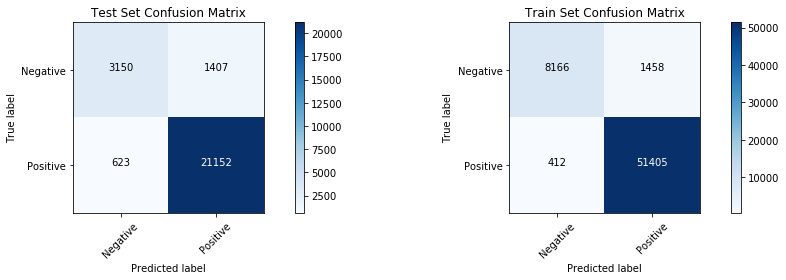

In [77]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_bow_l2.predict(X_test_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_bow_l2.predict(X_train_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the BoW vectorizer, we calculated C = 0.001 using GridSearchCV with cv = 5 and with penalty l2. 
2. We got train AUC: 0.99309054211035 and test AUC: 0.9415796492294188
3. Using the confusion matrix, we can say that our model correctly predicted 21152 positive reviews and 3150 negative reviews.
4. The model incorrectly classified 623 negative reviews and 1407 positive reviews.
5. The True Postive Rate is 98.67 and the True Negative Rate is 60.03
6. The accuracy of the model is 91.98

In [0]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

**Pertubation Test**

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>


In [78]:
# Step 1: Get the weights W after fitting your model with the data X
W_vect = model_bow_l2.coef_

In [79]:
# Step 2: Add a noise to the X (X' = X+e) and get the new dataset X'

# We need to preserve our existing X and create a copy of it before we can add noise to it
# source: https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/
# deepcopy(): any changes made to a copy of object do not reflect in the original object. 

import copy
X_train_bow_noisy = copy.deepcopy(X_train_bow) # copy of X_train_bow
uniform_noise = np.random.uniform(-0.0001,0.0001,1 ) # adding some random uniform noise

In [80]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [81]:
# Since X_train_bow is space matrix, we do X.data += e
X_train_bow_noisy.data += uniform_noise  
print(X_train_bow_noisy.shape)

(61441, 10000)


In [82]:
# Step 3: We fit the model again on data X_train_bow_noisy and get the weights W'

# Fitting the BoW vectorizer on LogisticRegression Model 
model_bow_l2_noisy = LogisticRegression(C= list(best_estimator_bow_l2.values())[0],penalty = 'l2')
model_bow_l2_noisy.fit(X_train_bow_noisy,y_train)
y_pred = model_bow_l2_noisy.predict(X_test_bow)

In [83]:
# Get the weights W after fitting your model with the noisy data X'
W_vect_noisy = model_bow_l2_noisy.coef_

In [84]:
# Step 4: Add small epsilon value to eliminate the 'divisible by zero' error to W_vect and W_vect_noisy
esp = 10**-6
W_vect += esp
W_vect_noisy += esp

In [85]:
# Step 5: Find % change between W_vect and W_vect_noisy

W_percent_change_vector = abs((W_vect - W_vect_noisy) / W_vect) *100

In [86]:
W_percent_change_vector

array([[9.93e-04, 7.01e-06, 1.03e-02, ..., 2.59e-03, 5.13e-04, 6.51e-03]])

+-------------+------------------------+
| Percentile  |    Percentile Value    |
+-------------+------------------------+
|      0      |  2.1288236710142e-08   |
|      10     | 0.0001290710220424033  |
|      20     | 0.00026651132954525614 |
|      30     |  0.000404709561975814  |
|      40     |  0.000581215567616487  |
|      50     | 0.0007999871796000233  |
|      60     | 0.0010965094631658796  |
|      70     | 0.0015858030927552692  |
|      80     |  0.002512170755860659  |
|      90     |  0.005024878518104683  |
|     100     |   12.572261483067537   |
+-------------+------------------------+


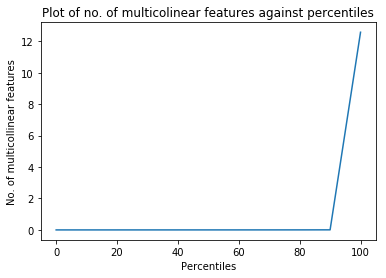

In [87]:
# Step 6: Calculate 0th, 10th, 20th ..100th Percentile
percentile_range= range(0,101,10)
tab = PrettyTable()
tab.field_names = ['Percentile ', 'Percentile Value']
    
    
for p in percentile_range:
    tab.add_row([p, np.percentile(W_percent_change_vector,p)])
    
    
plt.plot(percentile_range, np.percentile(W_percent_change_vector,percentile_range))
plt.xlabel('Percentiles')
plt.ylabel('No. of multicollinear features')
plt.title("Plot of no. of multicolinear features against percentiles")

print(tab)
del (tab)

**Observation:** We see that there is a sudden rise in values after the 90th percentile value. 

+-------------+----------------------+
| Percentile  |   Percentile Value   |
+-------------+----------------------+
|      90     | 0.005024878518104683 |
|      91     | 0.005536440548611815 |
|      92     | 0.006223372849219215 |
|      93     | 0.007020458291498725 |
|      94     | 0.008347083172674468 |
|      95     | 0.00971386294287677  |
|      96     | 0.011739505021271607 |
|      97     | 0.016008687942597848 |
|      98     | 0.024976125423512584 |
|      99     | 0.047399636184165865 |
|     100     |  12.572261483067537  |
+-------------+----------------------+


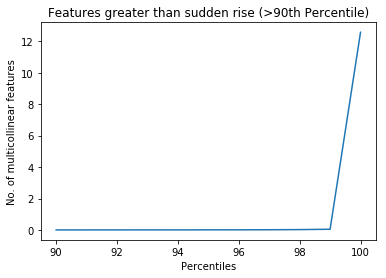

In [88]:
# Plot values after the sudden rise i.e. from the 90th percentile values

sudden_rise= range(90,101,1)
tab = PrettyTable()
tab.field_names = ['Percentile ', 'Percentile Value']

for i in sudden_rise:
    tab.add_row([i, np.percentile(W_percent_change_vector,i)])
    
print(tab)
plt.plot(sudden_rise,np.percentile(W_percent_change_vector,sudden_rise) );
plt.xlabel('Percentiles')
plt.ylabel('No. of multicollinear features')
plt.title("Features greater than sudden rise (>90th Percentile)")
del (tab)

**Observation:** Here, after 99th percentile, we see there is sudden rise in values.

+-------------------+----------------------+
|    Percentile     |   Percentile Value   |
+-------------------+----------------------+
|        99.0       | 0.047399636184165865 |
| 99.11111111111111 | 0.052915605599829704 |
| 99.22222222222223 | 0.05635737937635935  |
| 99.33333333333333 | 0.06811388084312188  |
| 99.44444444444444 | 0.08260693710378353  |
| 99.55555555555556 | 0.10265356775837843  |
| 99.66666666666667 | 0.12710099736555297  |
| 99.77777777777777 | 0.21553890490009822  |
| 99.88888888888889 |  0.6702054059627296  |
|       100.0       |  12.572261483067537  |
+-------------------+----------------------+


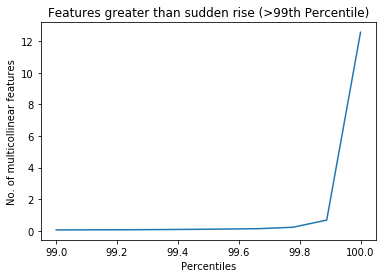

In [89]:
# Plot values after the sudden rise i.e. from the 90th percentile values

gt99= np.linspace(99,100,10)
tab = PrettyTable()
tab.field_names = ['Percentile ', 'Percentile Value']

for i in gt99:
    tab.add_row([i, np.percentile(W_percent_change_vector,i)])
    
print(tab)
plt.plot(gt99,np.percentile(W_percent_change_vector,gt99) );
plt.xlabel('Percentiles')
plt.ylabel('No. of multicollinear features')
plt.title("Features greater than sudden rise (>99th Percentile)")
del (tab)

**Observation:** In this case the threshold value is the percentile **99.88**

In [90]:
# We will list down the features names which are greater than this index value of threshold. 
# We will print top 10 features by sorting values in descending values of the % changed vector


feature_names = bow_vectorizer.get_feature_names() # get feature names
weight_vector_values = model_bow_l2_noisy.coef_    # get weight values

# sorting change in percent weight vector in descending order i.e. features that have undergone maximum collinearity 
# and selecting top 10 features out of it
mulc_features = np.argsort(W_percent_change_vector)[:,::-1][0,0:10]  

# Top 10 features are    
print("Printing 10 features:")

#tab = PrettyTable()
#tab.field_names = ['Feature name', 'Weight vector value']

for f in mulc_features:
    print(feature_names[f])
    #tab.add_row([feature_names[f], weight_vector_values[0,f]])
    
    
#print(tab)
#del(tab)

Printing 10 features:
minimal
free dairy
include
bowl
started using
quantity
good chocolate
not amazon
drink good
organic ingredients


**Observation**
1. We performed the perturbation test to find multicolinearity.
2. Here, we can see that very few features are collinear. Less than 0.02% features are multicolinear
3. We can conclude that this model is not affected by multicolinearity of features

**feature importance**

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

In [91]:
model_bow_l2.classes_

array([0, 1], dtype=int64)

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>



In [92]:
most_informative_feature_for_binary_classification(bow_vectorizer, model_bow_l2)

+-------+--------------------------+---------------+
| Class | Coefficient (Importance) |  Feature Name |
+-------+--------------------------+---------------+
|   0   |   0.18118765370558954    |  disappointed |
|   0   |    0.1637476142766516    |     worst     |
|   0   |    0.1450317900116653    | not recommend |
|   0   |    0.1437890099604434    |    not good   |
|   0   |   0.14138196686305474    |   not worth   |
|   0   |    0.1394686428948509    |      not      |
|   0   |   0.13404722441563235    |    terrible   |
|   0   |   0.13008740467603347    |     awful     |
|   0   |   0.12911041632708453    |    not buy    |
|   0   |   0.12699445630766656    | disappointing |
+-------+--------------------------+---------------+
****************************************************
+-------+--------------------------+--------------+
| Class | Coefficient (Importance) | Feature Name |
+-------+--------------------------+--------------+
|   1   |    0.3205556750029913    |    great    

## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
#count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
#final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
#print("the type of count vectorizer ",type(final_bigram_counts))
#print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [93]:
# ss
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
#X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
#print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(61441, 36173) (61441,)
(26332, 36173) (26332,)


In [94]:
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of cut text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words: ", X_train_tfidf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text TFIDF vectorizer  (61441, 36173)
the number of unique words:  36173


### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

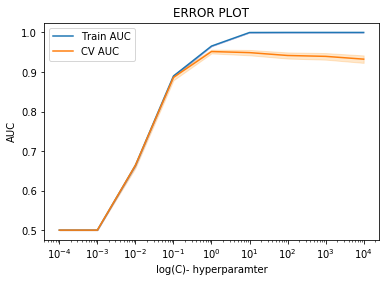

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|      0.5      |     0.0      | {'C': 0.0001} |
|      0.5      |     0.0      |  {'C': 0.001} |
|     0.664     |   0.01405    |  {'C': 0.01}  |
|     0.886     |   0.01464    |   {'C': 0.1}  |
|     0.952     |   0.00962    |    {'C': 1}   |
|     0.949     |   0.01358    |   {'C': 10}   |
|     0.942     |   0.01555    |   {'C': 100}  |
|      0.94     |    0.0167    |  {'C': 1000}  |
|     0.932     |   0.01891    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The best score is:0.9516803305794055
The best value of C is:{'C': 1}
Mean Score:

In [95]:
# Get the best hyperparameter using GridSearchCV with penalty l1 and cv = 5
best_estimator_tfidf_l1 = get_best_hyperparameter_C(tf_idf_vect, X_train_tfidf, X_test_tfidf, y_train, y_test, penalty_l = 'l1' )

In [96]:
# Fitting the model with the best hyperparameter
model_tfidf_l1 = LogisticRegression(C= list(best_estimator_tfidf_l1.values())[0] ,penalty = 'l1')
model_tfidf_l1.fit(X_train_tfidf,y_train)
y_pred = model_tfidf_l1.predict(X_test_tfidf)

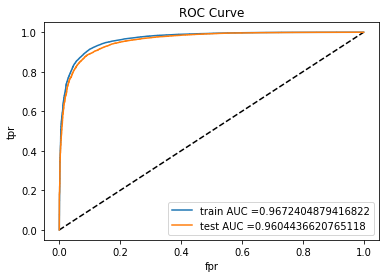

train AUC: 0.9672404879416822
test AUC: 0.9604436620765118


In [97]:
# AUC- ROC plot
auc_train_tfidf_l1, auc_test_tfidf_l1 = plot_auc(model_tfidf_l1, X_train_tfidf, X_test_tfidf)

In [98]:
# Confusion Matrix
print_confusion_matrix(model_tfidf_l1, X_train_tfidf, X_test_tfidf)

*****Train confusion matrix*****
[[ 6578  3046]
 [  871 50946]]

*****Test confusion matrix*****
[[ 3056  1501]
 [  496 21279]]


<Figure size 432x288 with 0 Axes>

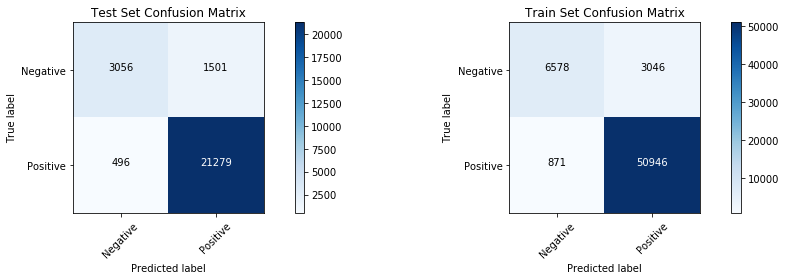

In [99]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidf_l1.predict(X_test_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidf_l1.predict(X_train_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the TFIDF vectorizer, we calculated C = 1 using GridSearchCV with cv = 5 and with penalty l1. 
2. We got train AUC: 0.9672404879416822 and test AUC: 0.9604436620765118
3. Using the confusion matrix, we can say that our model correctly predicted 21279 positive reviews and 3055 negative reviews.
4. The model incorrectly classified 496 negative reviews and 1501 positive reviews.
5. The True Postive Rate is 97.84 and the True Negative Rate is 67.03
6. The accuracy of the model is 92.50

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

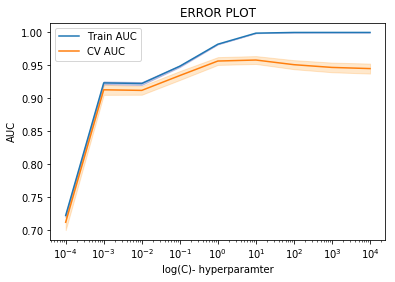

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|     0.712     |   0.02389    | {'C': 0.0001} |
|     0.913     |   0.01532    |  {'C': 0.001} |
|     0.912     |   0.01319    |  {'C': 0.01}  |
|     0.935     |   0.01353    |   {'C': 0.1}  |
|     0.957     |   0.01182    |    {'C': 1}   |
|     0.958     |   0.01198    |   {'C': 10}   |
|     0.951     |   0.01371    |   {'C': 100}  |
|     0.947     |   0.01465    |  {'C': 1000}  |
|     0.945     |   0.01516    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The best score is:0.95818493762303
The best value of C is:{'C': 10}
Mean Score:

In [100]:
# Get the best hyperparameter
best_estimator_tfidf_l2 = get_best_hyperparameter_C(tf_idf_vect, X_train_tfidf, X_test_tfidf, y_train, y_test, penalty_l = 'l2' )

In [101]:
# Fit the model with the best hyperparameter
model_tfidf_l2 = LogisticRegression(C= list(best_estimator_tfidf_l2.values())[0], penalty = 'l2')
model_tfidf_l2.fit(X_train_tfidf,y_train)
y_pred = model_tfidf_l2.predict(X_test_tfidf)

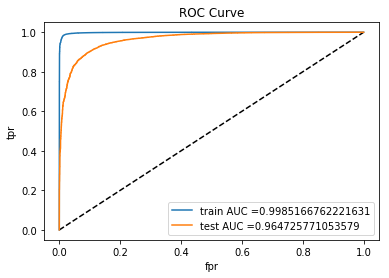

train AUC: 0.9985166762221631
test AUC: 0.964725771053579


In [102]:
# AUC- ROC plot
auc_train_tfidf_l2, auc_test_tfidf_l2 = plot_auc(model_tfidf_l2, X_train_tfidf, X_test_tfidf)

In [103]:
# Confusion matrix
print_confusion_matrix(model_tfidf_l2, X_train_tfidf, X_test_tfidf)

*****Train confusion matrix*****
[[ 8946   678]
 [  173 51644]]

*****Test confusion matrix*****
[[ 3248  1309]
 [  566 21209]]


<Figure size 432x288 with 0 Axes>

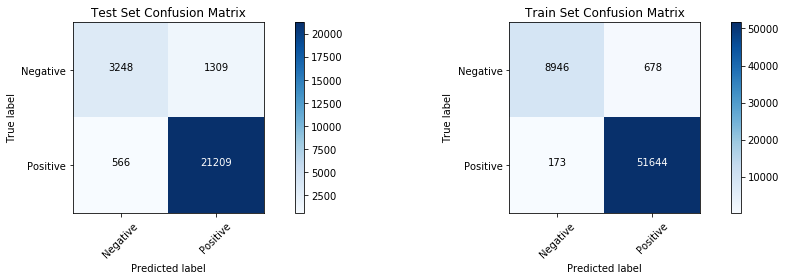

In [104]:
# Heatmap confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidf_l2.predict(X_test_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidf_l2.predict(X_train_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the TF-IDF vectorizer, we calculated C = 10 using GridSearchCV with cv = 5 and with penalty l2. 
2. We got train AUC: 0.9985166762221631 and test AUC: 0.964725771053579
3. Using the confusion matrix, we can say that our model correctly predicted 21209 positive reviews and 3248 negative reviews.
4. The model incorrectly classified 566 negative reviews and 1309 positive reviews.
5. The True Postive Rate is 98.47 and the True Negative Rate is 60.21
6. The accuracy of the model is 91.85

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [105]:
most_informative_feature_for_binary_classification(tf_idf_vect, model_tfidf_l2)

+-------+--------------------------+----------------+
| Class | Coefficient (Importance) |  Feature Name  |
+-------+--------------------------+----------------+
|   0   |    14.05633689502798     |     worst      |
|   0   |    11.74311885235004     |   not worth    |
|   0   |    11.712297104959422    |  disappointed  |
|   0   |    11.553933190987355    |    terrible    |
|   0   |    11.31806567269511     |    not good    |
|   0   |    11.294343181493128    | not recommend  |
|   0   |    11.235079122127873    |   two stars    |
|   0   |    10.916559085516361    |     awful      |
|   0   |    10.615169158405667    | disappointing  |
|   0   |    9.237292164583296     | disappointment |
+-------+--------------------------+----------------+
****************************************************
+-------+--------------------------+------------------+
| Class | Coefficient (Importance) |   Feature Name   |
+-------+--------------------------+------------------+
|   1   |    16.2298616

## [4.4] Word2Vec

In [106]:
# Train your own Word2Vec model using your own text corpus 
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [108]:
print(list_of_sentance_train[0])

['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'flies', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'flies', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching']


In [109]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8422129154205322), ('good', 0.8153432011604309), ('excellent', 0.813062310218811), ('awesome', 0.8104643821716309), ('wonderful', 0.8010066747665405), ('terrific', 0.7817002534866333), ('perfect', 0.767562747001648), ('amazing', 0.7452276945114136), ('fabulous', 0.7190866470336914), ('decent', 0.7043147087097168)]
[('greatest', 0.7702896595001221), ('best', 0.7596640586853027), ('tastiest', 0.7124402523040771), ('nastiest', 0.6849291920661926), ('coolest', 0.6719734072685242), ('closest', 0.6640547513961792), ('toughest', 0.6579124927520752), ('disgusting', 0.6277365684509277), ('smoothest', 0.6193704605102539), ('ive', 0.6013782024383545)]


In [110]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14799
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


**Converting train text data**

In [111]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61441/61441 [01:45<00:00, 582.36it/s]


(61441, 50)
[ 0.26 -0.27  0.11  0.07 -0.18  0.39 -0.26 -0.31  0.17 -0.01  0.11  0.45
  0.32  0.34 -0.19 -0.17  0.37  0.16 -0.03  0.3   0.21  0.57 -0.26 -0.3
  0.73  0.11 -0.03  0.08  0.11  0.47  0.11 -0.14 -0.19  0.14 -0.36 -0.38
 -0.04  0.02  0.57 -0.16  0.78  0.28 -0.42 -0.04  0.11 -0.41 -0.28 -0.21
 -0.74 -0.19]


**Converting test text data**

In [112]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [113]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)

print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26332/26332 [00:48<00:00, 539.88it/s]


(26332, 50)
[-0.4  -0.13 -0.11 -0.54  0.27 -0.05  0.48 -0.41  1.71  0.11  0.21  0.17
  0.04  0.53 -0.26 -0.07  1.08  0.26  0.04 -0.26  0.4  -1.23 -0.03 -0.5
  0.68 -0.36 -0.38  0.14 -0.58  0.17  0.21 -0.55 -0.05  0.75 -0.48  0.13
 -0.84 -0.25 -0.57 -0.24 -0.56 -0.76  0.55  0.55 -0.16 -0.36  0.34  0.22
 -0.49 -0.27]


hyperparameter tuning with cv = 5 using gridsearch

In [139]:
# Get the best hyperparameter
tuned_parameters = [{'C': [10**-4, 10**-3,10**-2, 10**-1,10**0, 10**1, 10**2, 10**3, 10**4]}]
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]  #k

# Using GridSearchCVSearchCV with 5 fold cv
gs_obj = GridSearchCV(LogisticRegression(penalty= 'l1'), tuned_parameters, scoring = 'roc_auc', cv=5)

gs_obj.fit(sent_vectors_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [131]:
best_estimator_w2v_l1 = gs_obj.best_params_

In [132]:
list(best_estimator_w2v_l1.values())[0]

100

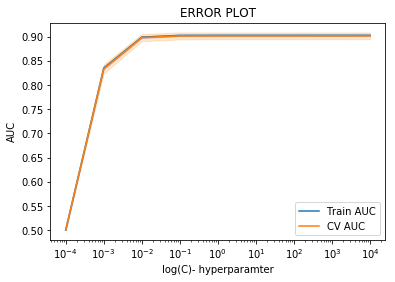

In [140]:
train_auc= gs_obj.cv_results_['mean_train_score']
train_auc_std= gs_obj.cv_results_['std_train_score']
cv_auc = gs_obj.cv_results_['mean_test_score'] 
cv_auc_std= gs_obj.cv_results_['std_test_score']

# draws the error plot
  
plt.plot(alpha, train_auc, label='Train AUC')

# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039 
plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C)- hyperparamter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOT")
plt.show()

In [141]:
# Results of the gs object
# Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
means = gs_obj.cv_results_['mean_test_score']
stds = gs_obj.cv_results_['std_test_score']


t1 = PrettyTable()
t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
    t1.add_row([round(mean, 3), round(std * 2,5), params])

print(t1) 
  
print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
print("\nThe best score is:{}".format(gs_obj.best_score_))
print("The best value of C is:{}".format(gs_obj.best_params_))

# Returns the mean accuracy on the given test data and labels.
print("Mean Score: {}".format(gs_obj.score(sent_vectors_test, y_test)))

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|      0.5      |     0.0      | {'C': 0.0001} |
|     0.833     |   0.01844    |  {'C': 0.001} |
|     0.898     |   0.01507    |  {'C': 0.01}  |
|     0.901     |    0.0144    |   {'C': 0.1}  |
|     0.901     |   0.01406    |    {'C': 1}   |
|     0.901     |   0.01405    |   {'C': 10}   |
|     0.901     |   0.01404    |   {'C': 100}  |
|     0.901     |   0.01399    |  {'C': 1000}  |
|     0.901     |   0.01404    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The best score is:0.901461054602771
The best value of C is:{'C': 1000}
Mean S

In [142]:
# Fitting the model with the best hyperparameter
model_avgw2v_l1 = LogisticRegression(C= list(best_estimator_w2v_l1.values())[0],penalty = 'l1')
model_avgw2v_l1.fit(sent_vectors_train,y_train)
y_pred = model_avgw2v_l1.predict(sent_vectors_test)

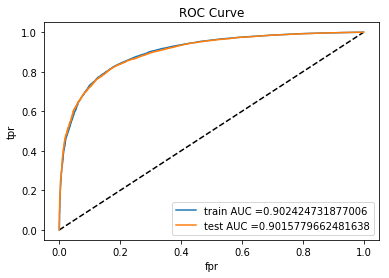

train AUC: 0.902424731877006
test AUC: 0.9015779662481638


In [143]:
# AUC - ROC plot
auc_train_avgw2v_l1, auc_test_avgw2v_l1 = plot_auc(model_avgw2v_l1, sent_vectors_train, sent_vectors_test)

In [144]:
# Confusion matrix
print_confusion_matrix(model_avgw2v_l1, sent_vectors_train, sent_vectors_test)

*****Train confusion matrix*****
[[ 4454  5170]
 [ 1726 50091]]

*****Test confusion matrix*****
[[ 2146  2411]
 [  788 20987]]


<Figure size 432x288 with 0 Axes>

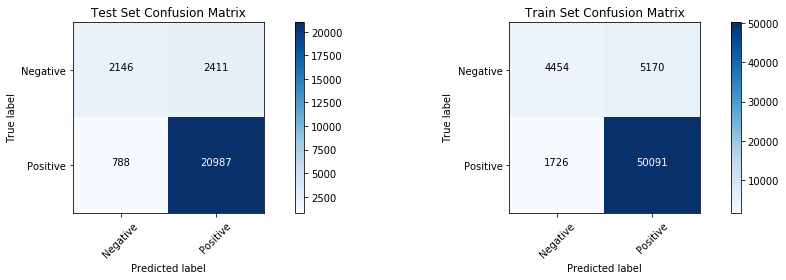

In [156]:
# Heatmap confusion matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_avgw2v_l1.predict(sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_avgw2v_l1.predict(sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the BoW vectorizer, we calculated C = 1000 using GridSearchCV with cv = 5 and with penalty l1. 
2. We got train AUC: 0.902424731877006 and test AUC: 0.9015779662481638
3. Using the confusion matrix, we can say that our model correctly predicted 20987 positive reviews and 2146 negative reviews.
4. The model incorrectly classified 788 negative reviews and 2411 positive reviews.
5. The True Postive Rate is 96.41 and the True Negative Rate is 47.65
6. The accuracy of the model is 87.97



### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [146]:
# Get the best hyperparameter
tuned_parameters = [{'C': [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}]
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]  #k

# Using GridSearchCVSearchCV with 5 fold cv
gs_obj = GridSearchCV(LogisticRegression(penalty= 'l2'), tuned_parameters, scoring = 'roc_auc', cv=5)

gs_obj.fit(sent_vectors_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

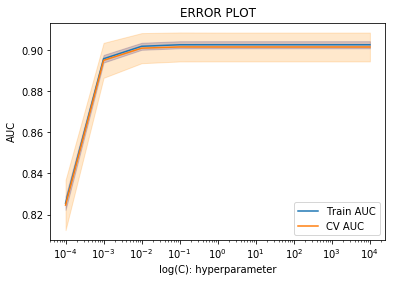

In [147]:
train_auc= gs_obj.cv_results_['mean_train_score']
train_auc_std= gs_obj.cv_results_['std_train_score']
cv_auc = gs_obj.cv_results_['mean_test_score'] 
cv_auc_std= gs_obj.cv_results_['std_test_score']

# draws the error plot
  
plt.plot(alpha, train_auc, label='Train AUC')
 # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039 
plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOT")
plt.show()

In [148]:
# Results of the gs object
# Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
means = gs_obj.cv_results_['mean_test_score']
stds = gs_obj.cv_results_['std_test_score']


t2 = PrettyTable()
t2.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
    t2.add_row([round(mean, 3), round(std * 2,5), params])

print(t2) 
  
print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
print("\nThe best score is:{}".format(gs_obj.best_score_))
print("The best value of C is:{}".format(gs_obj.best_params_))

# Returns the mean accuracy on the given test data and labels.
print("Mean Score: {}".format(gs_obj.score(sent_vectors_test, y_test)))

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|     0.825     |   0.02433    | {'C': 0.0001} |
|     0.895     |   0.01698    |  {'C': 0.001} |
|     0.901     |   0.01463    |  {'C': 0.01}  |
|     0.901     |    0.0141    |   {'C': 0.1}  |
|     0.901     |   0.01402    |    {'C': 1}   |
|     0.901     |   0.01401    |   {'C': 10}   |
|     0.901     |   0.01401    |   {'C': 100}  |
|     0.901     |   0.01402    |  {'C': 1000}  |
|     0.901     |   0.01402    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The best score is:0.9014769955102173
The best value of C is:{'C': 0.1}
Mean Sc

In [149]:
best_estimator_w2v_l2 = gs_obj.best_params_

In [150]:
# Fitting the Avg W2v vectorizer on LogisticRegression Model with  penalty = 'l2'
model_avgw2v_l2 = LogisticRegression(C= list(best_estimator_w2v_l2.values())[0],penalty = 'l2')
model_avgw2v_l2.fit(sent_vectors_train,y_train)
y_pred = model_avgw2v_l2.predict(sent_vectors_test)

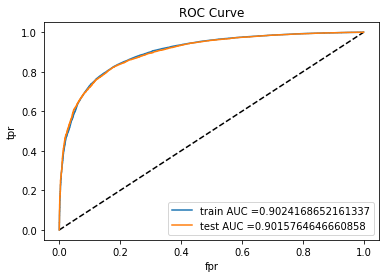

train AUC: 0.9024168652161337
test AUC: 0.9015764646660858


In [151]:
# AUC- ROC plot
auc_train_avgw2v_l2, auc_test_avgw2v_l2 = plot_auc(model_avgw2v_l2, sent_vectors_train, sent_vectors_test)

In [152]:
# Confusion Matrix
print_confusion_matrix(model_avgw2v_l2, sent_vectors_train, sent_vectors_test)

*****Train confusion matrix*****
[[ 4410  5214]
 [ 1688 50129]]

*****Test confusion matrix*****
[[ 2113  2444]
 [  768 21007]]


<Figure size 432x288 with 0 Axes>

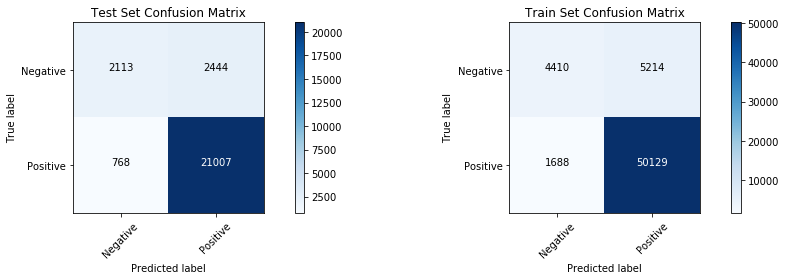

In [155]:
# Heatmap confusion matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_avgw2v_l2.predict(sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_avgw2v_l2.predict(sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the BoW vectorizer, we calculated C = 0.1 using GridSearchCV with cv = 5 and with penalty l2. 
2. We got train AUC: 0.9024168652161337 and test AUC: 0.9015764646660858
3. Using the confusion matrix, we can say that our model correctly predicted 21007 positive reviews and 2113 negative reviews.
4. The model incorrectly classified 768 negative reviews and 2444 positive reviews.
5. The True Postive Rate is 96.42 and the True Negative Rate is 47.59
6. The accuracy of the model is 87.97


#### [4.4.1.2] TFIDF weighted W2v

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [114]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
X_train_tf_idf_w2v = model.fit_transform(X_train)
X_test_tf_idf_w2v = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [115]:
# TF-IDF weighted Word2Vec for sentences in X_train
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61441/61441 [27:08<00:00, 37.73it/s]


In [116]:
# TF-IDF weighted Word2Vec for sentences in X_test
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26332/26332 [11:50<00:00, 37.08it/s]


### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

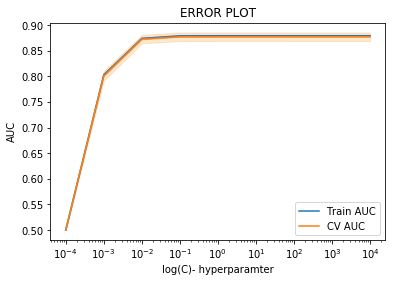

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|      0.5      |     0.0      | {'C': 0.0001} |
|     0.801     |   0.01918    |  {'C': 0.001} |
|     0.872     |   0.01642    |  {'C': 0.01}  |
|     0.877     |   0.01663    |   {'C': 0.1}  |
|     0.877     |    0.0166    |    {'C': 1}   |
|     0.877     |   0.01661    |   {'C': 10}   |
|     0.877     |   0.01661    |   {'C': 100}  |
|     0.877     |   0.01661    |  {'C': 1000}  |
|     0.877     |   0.01661    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The best score is:0.8769711699379582
The best value of C is:{'C': 1}
Mean Score:

In [117]:
best_estimator_tfidfw2v_l1 = get_best_hyperparameter_C(model, tfidf_sent_vectors_train, tfidf_sent_vectors_test, y_train, y_test, penalty_l = 'l1' )

In [118]:
# Fitting the TFIDF - weighted W2V vectorizer on LogisticRegression Model 
model_tfidfw2v_l1 = LogisticRegression(C= list(best_estimator_tfidfw2v_l1.values())[0], penalty = 'l1')
model_tfidfw2v_l1.fit(tfidf_sent_vectors_train,y_train)
y_pred = model_tfidfw2v_l1.predict(tfidf_sent_vectors_test)

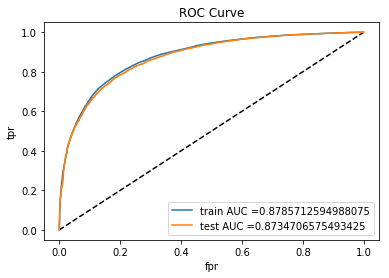

train AUC: 0.8785712594988075
test AUC: 0.8734706575493425


In [119]:
# AUC- ROC plot
auc_train_tfidfw2v_l1, auc_test_tfidfw2v_l1 = plot_auc(model_tfidfw2v_l1, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

In [120]:
# Confusion Matrix
print_confusion_matrix(model_tfidfw2v_l1, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

*****Train confusion matrix*****
[[ 3636  5988]
 [ 1577 50240]]

*****Test confusion matrix*****
[[ 1731  2826]
 [  704 21071]]


<Figure size 432x288 with 0 Axes>

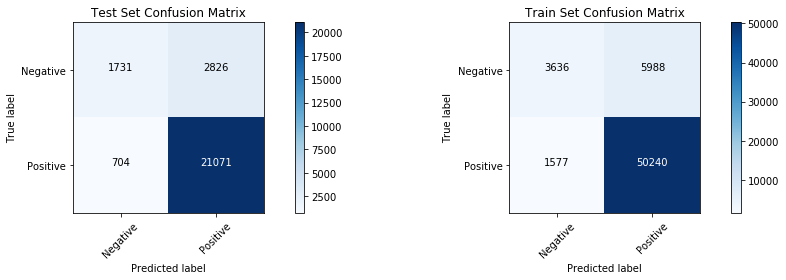

In [121]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidfw2v_l1.predict(tfidf_sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidfw2v_l1.predict(tfidf_sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the BoW vectorizer, we calculated C = 1 using GridSearchCV with cv = 5 and with penalty l1. 
2. We got train AUC: 0.8785712594988075 and test AUC: 0.8734706575493425
3. Using the confusion matrix, we can say that our model correctly predicted 21071 positive reviews and 1731 negative reviews.
4. The model incorrectly classified 704 negative reviews and 2826 positive reviews.
5. The True Postive Rate is 96.60 and the True Negative Rate is 39.52
6. The accuracy of the model is 86.72

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

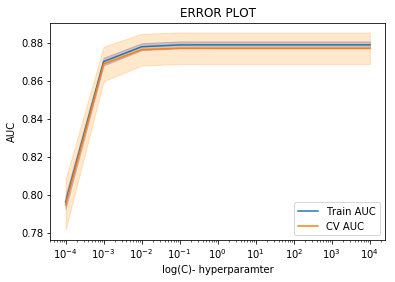

+---------------+--------------+---------------+
| Mean CV Score | Std CV Score |     Param     |
+---------------+--------------+---------------+
|     0.795     |   0.02675    | {'C': 0.0001} |
|     0.869     |   0.01828    |  {'C': 0.001} |
|     0.876     |   0.01677    |  {'C': 0.01}  |
|     0.877     |   0.01661    |   {'C': 0.1}  |
|     0.877     |   0.01662    |    {'C': 1}   |
|     0.877     |   0.01661    |   {'C': 10}   |
|     0.877     |   0.01661    |   {'C': 100}  |
|     0.877     |   0.01661    |  {'C': 1000}  |
|     0.877     |   0.01661    |  {'C': 10000} |
+---------------+--------------+---------------+

The best estimator:LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The best score is:0.8769926148015947
The best value of C is:{'C': 0.1}
Mean Sc

In [122]:
best_estimator_tfidfw2v_l2 = get_best_hyperparameter_C(model, tfidf_sent_vectors_train, tfidf_sent_vectors_test, y_train, y_test, penalty_l = 'l2' )

In [123]:
# Fitting the TFIDF - weighted W2V vectorizer on LogisticRegression Model with C =  and penalty = 'l2'
model_tfidfw2v_l2 = LogisticRegression(C= list(best_estimator_tfidfw2v_l2.values())[0],penalty = 'l2')
model_tfidfw2v_l2.fit(tfidf_sent_vectors_train,y_train)
y_pred = model_tfidfw2v_l2.predict(tfidf_sent_vectors_test)

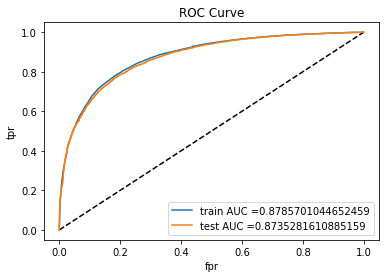

train AUC: 0.8785701044652459
test AUC: 0.8735281610885159


In [124]:
# AUC- ROC plot
auc_train_tfidfw2v_l2, auc_test_tfidfw2v_l2 = plot_auc(model_tfidfw2v_l2, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

In [125]:
# Confusion Matrix
print_confusion_matrix(model_tfidfw2v_l2, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

*****Train confusion matrix*****
[[ 3607  6017]
 [ 1548 50269]]

*****Test confusion matrix*****
[[ 1708  2849]
 [  690 21085]]


<Figure size 432x288 with 0 Axes>

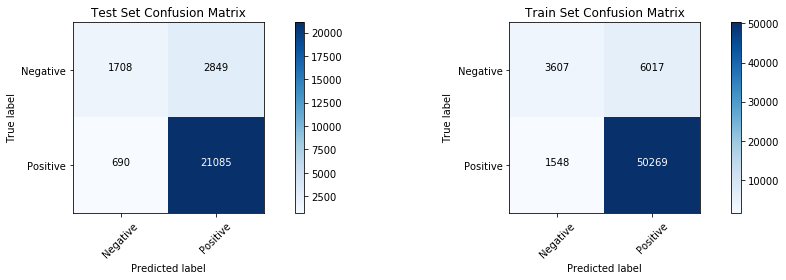

In [126]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidfw2v_l2.predict(tfidf_sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidfw2v_l2.predict(tfidf_sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the TFIDF-W2V vectorizer, we calculated C = 0.1 using GridSearchCV with cv = 5 and with penalty l2. 
2. We got train AUC: 0.8785701044652459 and test AUC: 0.8735281610885159
3. Using the confusion matrix, we can say that our model correctly predicted 21085 positive reviews and 1702 negative reviews.
4. The model incorrectly classified 690 negative reviews and 2849 positive reviews.
5. The True Postive Rate is 96.6 and the True Negative Rate is 39.54
6. The accuracy of the model is 86.73

# Conclusions

In [157]:
C = PrettyTable()

C.field_names = ['Sr. No', 'Vectorizer','Norm','C', 'Train AUC', 'Test AUC']
C.add_row([1, 'BoW', 'L1', list(best_estimator_bow_l1.values())[0], auc_train_bow_l1, auc_train_bow_l1])
C.add_row([1, 'BoW', 'L2',list(best_estimator_bow_l2.values())[0] ,auc_train_bow_l2 ,auc_test_bow_l2])
C.add_row([1, 'TF_IDF', 'L1', list(best_estimator_tfidf_l1.values())[0], auc_train_tfidf_l1, auc_test_tfidf_l1])
C.add_row([1, 'TF_IDF', 'L2',list(best_estimator_tfidf_l2.values())[0] , auc_train_tfidf_l2, auc_train_tfidf_l2])
C.add_row([1, 'Avg-W2V', 'L1',list(best_estimator_w2v_l1.values())[0] ,auc_train_avgw2v_l1 ,auc_test_avgw2v_l1])
C.add_row([1, 'Avg-W2V', 'L2', list(best_estimator_w2v_l2.values())[0],auc_train_avgw2v_l2 ,auc_test_avgw2v_l2])
C.add_row([1, 'TFIDF-W2V', 'L1',list(best_estimator_tfidfw2v_l1.values())[0] ,auc_train_tfidfw2v_l1, auc_test_tfidfw2v_l1])
C.add_row([1, 'TFIDF-W2V', 'L2', list(best_estimator_tfidfw2v_l2.values())[0], auc_train_tfidfw2v_l2,auc_test_tfidfw2v_l2])
           

print(C)
del C

+--------+------------+------+-------+--------------------+--------------------+
| Sr. No | Vectorizer | Norm |   C   |     Train AUC      |      Test AUC      |
+--------+------------+------+-------+--------------------+--------------------+
|   1    |    BoW     |  L1  |  0.01 | 0.9695167883807346 | 0.9695167883807346 |
|   1    |    BoW     |  L2  | 0.001 |  0.99309054211035  | 0.9415796492294188 |
|   1    |   TF_IDF   |  L1  |   1   | 0.9672404879416822 | 0.9604436620765118 |
|   1    |   TF_IDF   |  L2  |   10  | 0.9985166762221631 | 0.9985166762221631 |
|   1    |  Avg-W2V   |  L1  |  100  | 0.902424731877006  | 0.9015779662481638 |
|   1    |  Avg-W2V   |  L2  |  0.1  | 0.9024168652161337 | 0.9015764646660858 |
|   1    | TFIDF-W2V  |  L1  |   1   | 0.8785712594988075 | 0.8734706575493425 |
|   1    | TFIDF-W2V  |  L2  |  0.1  | 0.8785701044652459 | 0.8735281610885159 |
+--------+------------+------+-------+--------------------+--------------------+


# Summary


1. We performed Logistic Regression with L1 and L2 normalization on BoW, TFIDF, Avg-W2V, TFIDF-WW2V on the Amazon Fine Food Reviews.
2. Made use of GridSearchCV to find the best value of C, the hyperparameter in logistic regression.
3. Performed Feature Engineering on the BoW model and found out the model slightly performed better.
4. Different vectors take on different C values. We saw C values being taken from  10**-4 to 10**4
5. We obtained the colinear features using perturbation and found out that we have less than 0.02% of colinear features.
6. If dataset is balanced, we can get better TNR.